In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from hetero.algo import align_binary_labels, group
from hetero.config import (
    DEFAULT_GROUP_REWARD_COEFF_OVERRIDE,
    DTYPE,
    AlgoConfig,
    DataGenConfig,
    DimConfig,
    GroupingConfig,
)
from hetero.datagen import generate_data_from_config
from hetero.policies import AllPosPolicy, AlternativePolicy
from hetero.utils import LabelPartitioner, remove_outlier

=====================================================================================================

In [2]:
# Linear setting hence no expansion settings.
# N=100 and N=40.

#true_reward_coeff = np.array

group_reward_coeff = np.array(
    [
        [-2, 2, 2, -2],
        [2, -2, -2, 2],
    ],
    dtype=DTYPE,
)

action_reward_coeff = [-1, 1]

data_config_init = dict(
    num_trajectories=100,
    num_time_steps=30,
    group_reward_coeff_override=group_reward_coeff,
    action_reward_coeff=action_reward_coeff,
    num_burnin_steps=100,
    basis_expansion_method="LEGENDRE",
    transformation_method="NORMCDF",
    noise_type="STUDENT",
    noise_student_degree=4,
)

data = generate_data_from_config(data_config)
pi_eval = AlternativePolicy(data_config.NUM_ACTIONS)
discount = 0.6

In [3]:
from hetero.algo import beta_from_linreg
from hetero.utils import action_feature_prod

Z = action_feature_prod(data.actions, data.current_features)
pi_eval_actions = pi_eval.action(data.next_features)
U = action_feature_prod(pi_eval_actions, data.next_features)
print(Z.shape, U.shape)
beta = beta_from_linreg(data, Z, U, discount)
print(beta.shape)

(8000, 8) (8000, 8)
(200, 8)


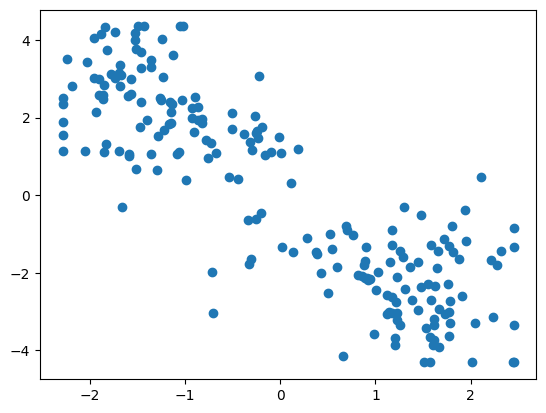

In [4]:
# Trajectory wise regression betas, only for demo.

init_beta = remove_outlier(beta, 2, 98)
plt.scatter(init_beta[:, 0], init_beta[:, 1])

In [5]:
# Compute trajectory wise betas with optimizer

from hetero.algo import BetaOptimizer, MCPImpl

base_config = dict(
    discount=discount,
    max_num_iters=10,
    nu_coeff=1e-6,
    delta_coeff=1e-6,
    use_group_wise_regression_init=True,
)

In [6]:
lam_list = [3.0, 2.0, 1.0]
rho_list = [10.0, 2.0, 2.0]

In [7]:
lam = lam_list[0]
rho = rho_list[0]

lam_and_beta = {}
lam_and_learned_labels = {}

algo_config = AlgoConfig(lam=lam, rho=rho, **base_config)
impl = MCPImpl(data.N(), algo_config)
beta_opt = BetaOptimizer(data, algo_config, pi_eval, impl)
lam_and_beta[lam] = beta_opt.compute()

learned_labels = group(lam_and_beta[lam], GroupingConfig())
truth = np.array([x[0] for x in data.partitioner.index_to_label_mapping()])
aligned_labels = align_binary_labels(learned_labels, truth)
print("Label mismatch =", (aligned_labels != truth).sum())
lam_and_learned_labels[lam] = aligned_labels

beta_solver, min eigen of left matrix = 0.70503086
MCPImpl: num_above=10656, num_below=9244
beta_solver, min eigen of left matrix = 0.70503086
MCPImpl: num_above=10481, num_below=9419
beta_solver, min eigen of left matrix = 0.70503086
MCPImpl: num_above=14994, num_below=4906
beta_solver, min eigen of left matrix = 0.70503086
MCPImpl: num_above=10365, num_below=9535
beta_solver, min eigen of left matrix = 0.70503086
MCPImpl: num_above=11239, num_below=8661
beta_solver, min eigen of left matrix = 0.70503086
MCPImpl: num_above=13035, num_below=6865
beta_solver, min eigen of left matrix = 0.70503086
MCPImpl: num_above=10417, num_below=9483
beta_solver, min eigen of left matrix = 0.70503086
MCPImpl: num_above=12105, num_below=7795
beta_solver, min eigen of left matrix = 0.70503086
MCPImpl: num_above=11049, num_below=8851
beta_solver, min eigen of left matrix = 0.70503086
MCPImpl: num_above=10851, num_below=9049
kmeans center = [[ 1.26124153 -2.35565756 -1.76822113  3.72082765  3.3683952  -1

In [8]:
lam = lam_list[1]
rho = rho_list[1]

algo_config = AlgoConfig(lam=lam, rho=rho, **base_config)
impl = MCPImpl(data.N(), algo_config)
beta_opt = BetaOptimizer(data, algo_config, pi_eval, impl)
lam_and_beta[lam] = beta_opt.compute()

learned_labels = group(lam_and_beta[lam], GroupingConfig())
truth = np.array([x[0] for x in data.partitioner.index_to_label_mapping()])
aligned_labels = align_binary_labels(learned_labels, truth)
print("Label mismatch =", (aligned_labels != truth).sum())
lam_and_learned_labels[lam] = aligned_labels

beta_solver, min eigen of left matrix = 0.70503086
MCPImpl: num_above=13681, num_below=6219
beta_solver, min eigen of left matrix = 0.70503086
MCPImpl: num_above=12294, num_below=7606
beta_solver, min eigen of left matrix = 0.70503086
MCPImpl: num_above=11808, num_below=8092
beta_solver, min eigen of left matrix = 0.70503086
MCPImpl: num_above=11748, num_below=8152
beta_solver, min eigen of left matrix = 0.70503086
MCPImpl: num_above=11640, num_below=8260
beta_solver, min eigen of left matrix = 0.70503086
MCPImpl: num_above=11498, num_below=8402
beta_solver, min eigen of left matrix = 0.70503086
MCPImpl: num_above=11619, num_below=8281
beta_solver, min eigen of left matrix = 0.70503086
MCPImpl: num_above=11678, num_below=8222
beta_solver, min eigen of left matrix = 0.70503086
MCPImpl: num_above=11585, num_below=8315
beta_solver, min eigen of left matrix = 0.70503086
MCPImpl: num_above=11822, num_below=8078
kmeans center = [[ 1.31018148 -2.29528453 -1.87164912  3.67066527  3.40357011 -1

In [9]:
lam = lam_list[2]
rho = rho_list[2]

algo_config = AlgoConfig(lam=lam, rho=rho, **base_config)
impl = MCPImpl(data.N(), algo_config)
beta_opt = BetaOptimizer(data, algo_config, pi_eval, impl)
lam_and_beta[lam] = beta_opt.compute()

learned_labels = group(lam_and_beta[lam], GroupingConfig())
truth = np.array([x[0] for x in data.partitioner.index_to_label_mapping()])
aligned_labels = align_binary_labels(learned_labels, truth)
print("Label mismatch =", (aligned_labels != truth).sum())
lam_and_learned_labels[lam] = aligned_labels

beta_solver, min eigen of left matrix = 0.70503086
MCPImpl: num_above=19005, num_below=895
beta_solver, min eigen of left matrix = 0.70503086
MCPImpl: num_above=19535, num_below=365
beta_solver, min eigen of left matrix = 0.70503086
MCPImpl: num_above=19025, num_below=875
beta_solver, min eigen of left matrix = 0.70503086
MCPImpl: num_above=19474, num_below=426
beta_solver, min eigen of left matrix = 0.70503086
MCPImpl: num_above=19042, num_below=858
beta_solver, min eigen of left matrix = 0.70503086
MCPImpl: num_above=19461, num_below=439
beta_solver, min eigen of left matrix = 0.70503086
MCPImpl: num_above=19030, num_below=870
beta_solver, min eigen of left matrix = 0.70503086
MCPImpl: num_above=19449, num_below=451
beta_solver, min eigen of left matrix = 0.70503086
MCPImpl: num_above=19044, num_below=856
beta_solver, min eigen of left matrix = 0.70503086
MCPImpl: num_above=19446, num_below=454
kmeans center = [[ 1.22093358 -2.25396334 -1.85023074  3.76284892  3.47130638 -0.99241215


In [10]:
# Compute group (pool trajectories of the same group together) wise regression betas.

from hetero import tasks

grouped_beta = tasks.beta_estimate_from_new_labels(
    data, [x[0] for x in data.labels], pi_eval, algo_config.discount
)[0]

new_labels.length=8000 matches number of records


In [11]:
# Use the clustered labels to compute cluster wise regression betas.
# Note that when the clusters are perfect, we will have:
# grouped_beta == clustered_beta

/var/folders/w6/sp20vq8s50z2h77z6ny7mh700000gn/T/ipykernel_25576/3749984779.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color=mpl.cm.get_cmap('tab20')(19),
/var/folders/w6/sp20vq8s50z2h77z6ny7mh700000gn/T/ipykernel_25576/3749984779.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color=mpl.cm.get_cmap('tab20')(0),


<Figure size 640x480 with 0 Axes>

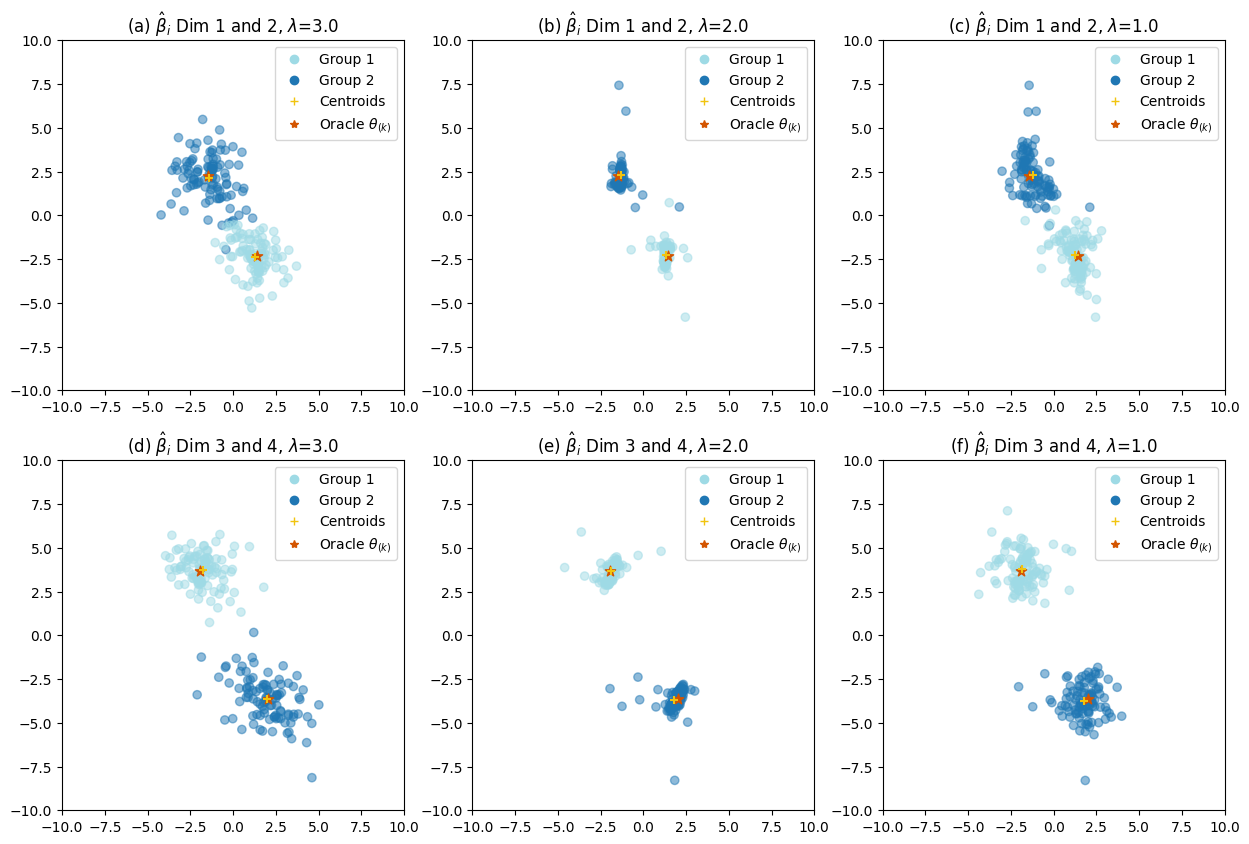

In [16]:
from matplotlib.lines import Line2D
import matplotlib as mpl

legend_elements = [Line2D([], [], 
                          color=mpl.cm.get_cmap('tab20')(19), 
                          marker='o', 
                          linestyle='None',
                          label='Group 1'),
                   Line2D([], [], 
                          color=mpl.cm.get_cmap('tab20')(0),
                          marker='o', 
                          linestyle='None',
                          label='Group 2'),
                   Line2D([], [], 
                          color='#F1C40F',
                          #markersize=30,
                          marker='+', 
                          linestyle='None',
                          label='Centroids'),
                   Line2D([], [], 
                          color='#D35400', 
                          #markersize=60,
                          marker='*', 
                          linestyle='None',
                          label='Oracle $\\theta_{(k)}$')]

#subs = [241, 242, 243, 244, 245, 246, 247, 248]
subs = [231, 232, 233, 234, 235, 236]
caps = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)']
all_lams = list(lam_and_beta.keys())
all_lams.sort(reverse=True)
all_lams += all_lams
assert len(subs) == len(all_lams)

plt.set_cmap('tab20')
fig = plt.figure(figsize=[15, 10])

for sub, lam, cap in zip(subs, all_lams, caps):
    ax = fig.add_subplot(sub)
    if sub % 10 in [1, 2, 3]:
        ax.scatter(
            lam_and_beta[lam][:, 0], 
            lam_and_beta[lam][:, 1], 
            c=truth, 
            #s=3, 
            #marker="x",
            alpha=0.5
        )
        beta_text = f"{cap} $\\hat\\beta_i$ Dim 1 and 2"
        ax.scatter(
            grouped_beta.betas[0][0],
            grouped_beta.betas[0][1],
            c='#D35400', # red
            s=60,
            marker="*",
        )
        ax.scatter(
            grouped_beta.betas[1][0],
            grouped_beta.betas[1][1],
            c='#D35400',
            s=60,
            marker="*",
        )

        masks = [
            [x == cluster for x in lam_and_learned_labels[lam]] for cluster in range(2)
        ]
        clustered_mean_beta = [
            lam_and_beta[lam][mask, :].mean(axis=0) for mask in masks
        ]
        ax.scatter(
            clustered_mean_beta[0][0],
            clustered_mean_beta[0][1],
            c='#F1C40F',  # yellow
            s=30,
            marker="+", 
        )
        ax.scatter(
            clustered_mean_beta[1][0],
            clustered_mean_beta[1][1],
            c='#F1C40F',
            s=30,
            marker="+",
        )
        
        ax.legend(handles=legend_elements, loc='upper right')
    else:
        ax.scatter(
            lam_and_beta[lam][:, 2], 
            lam_and_beta[lam][:, 3], 
            c=truth, 
            #s=3, 
            #marker="x",
            alpha=0.5
        )
        beta_text = f"{cap} $\\hat\\beta_i$ Dim 3 and 4"
        ax.scatter(
            grouped_beta.betas[0][2],
            grouped_beta.betas[0][3],
            c='#D35400', # red
            s=60,
            marker="*",
        )
        ax.scatter(
            grouped_beta.betas[1][2],
            grouped_beta.betas[1][3],
            c='#D35400', # red
            s=60,
            marker="*",
        )

        masks = [
            [x == cluster for x in lam_and_learned_labels[lam]] for cluster in range(2)
        ]
        clustered_mean_beta = [
            lam_and_beta[lam][mask, :].mean(axis=0) for mask in masks
        ]
        ax.scatter(
            clustered_mean_beta[0][2],
            clustered_mean_beta[0][3],
            c='#F1C40F',  # yellow
            s=30,
            marker="+", 
        )
        ax.scatter(
            clustered_mean_beta[1][2],
            clustered_mean_beta[1][3],
            c='#F1C40F',  # yellow
            s=30,
            marker="+", 
        )
        ax.legend(handles=legend_elements, loc='upper right')

    ax.title.set_text(beta_text + f", $\lambda$={lam}")
    ax.set_xlim([-10, 10])
    ax.set_ylim([-10, 10])

#plt.savefig(f'results/legendre_split_t.pdf', bbox_inches='tight')
plt.show()

/var/folders/w6/sp20vq8s50z2h77z6ny7mh700000gn/T/ipykernel_25576/896684200.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color=mpl.cm.get_cmap('tab20')(19),
/var/folders/w6/sp20vq8s50z2h77z6ny7mh700000gn/T/ipykernel_25576/896684200.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color=mpl.cm.get_cmap('tab20')(0),


<Figure size 640x480 with 0 Axes>

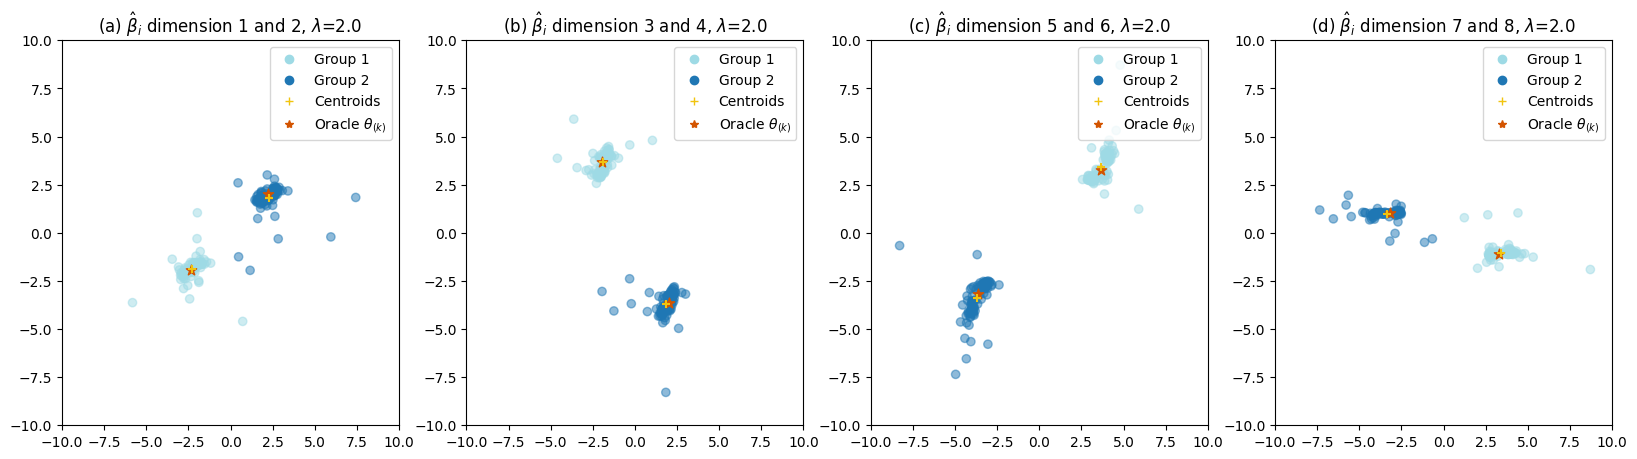

In [26]:
from matplotlib.lines import Line2D
import matplotlib as mpl

legend_elements = [Line2D([], [], 
                          color=mpl.cm.get_cmap('tab20')(19), 
                          marker='o', 
                          linestyle='None',
                          label='Group 1'),
                   Line2D([], [], 
                          color=mpl.cm.get_cmap('tab20')(0),
                          marker='o', 
                          linestyle='None',
                          label='Group 2'),
                   Line2D([], [], 
                          color='#F1C40F',
                          #markersize=30,
                          marker='+', 
                          linestyle='None',
                          label='Centroids'),
                   Line2D([], [], 
                          color='#D35400', 
                          #markersize=60,
                          marker='*', 
                          linestyle='None',
                          label='Oracle $\\theta_{(k)}$')]


subs = [141, 142, 143, 144]
caps = ['(a)', '(b)', '(c)', '(d)']
#all_lams = list(lam_and_beta.keys())
#all_lams.sort(reverse=True)
#all_lams += all_lams
#assert len(subs) == len(all_lams)

lam = lam_list[1]

plt.set_cmap('tab20')
fig = plt.figure(figsize=[20, 5])

for sub, cap in zip(subs, caps):
    ax = fig.add_subplot(sub)
    i = sub % 10
    ax.scatter(
        lam_and_beta[lam][:, i], 
        lam_and_beta[lam][:, i+1], 
        c=truth, 
        #s=3, 
        #marker="x",
        alpha=0.5
    )
    beta_text = f"{cap} $\\hat\\beta_i$ dimension {2*(i-1)+1} and {2*(i-1)+2}"
    ax.scatter(
        grouped_beta.betas[0][i],
        grouped_beta.betas[0][i+1],
        c='#D35400', # red
        s=60,
        marker="*",
    )
    ax.scatter(
        grouped_beta.betas[1][i],
        grouped_beta.betas[1][i+1],
        c='#D35400',
        s=60,
        marker="*",
    )

    masks = [
        [x == cluster for x in lam_and_learned_labels[lam]] for cluster in range(2)
    ]
    clustered_mean_beta = [
        lam_and_beta[lam][mask, :].mean(axis=0) for mask in masks
    ]
    ax.scatter(
        clustered_mean_beta[0][i],
        clustered_mean_beta[0][i+1],
        c='#F1C40F',  # yellow
        s=30,
        marker="+", 
    )
    ax.scatter(
        clustered_mean_beta[1][i],
        clustered_mean_beta[1][i+1],
        c='#F1C40F',
        s=30,
        marker="+",
    )

    ax.legend(handles=legend_elements, loc='upper right')

    ax.title.set_text(beta_text + f", $\lambda$={lam}")
    ax.set_xlim([-10, 10])
    ax.set_ylim([-10, 10])

plt.savefig(f'results/legendre_split.pdf', bbox_inches='tight')
plt.show()